In [1]:
%load_ext autoreload
%autoreload 2

# Fine-tuning foundation models

This notebook reviews methods to fine-tune two large "foundation" models for neural network potentials: CHGNet and MACE-MP-0. The models are fine-tuned using data from a set of Crystals in the toy database. This approach relies on freezing a subset of the layers of the model and training the remaining layers on the new data. There are other fine-tuning strategies, such as training the entire model with a smaller learning rate, but this notebook focuses on the former.

In [9]:
import os
import shutil

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error
from nff.train.transfer import ChgnetLayerFreezer, MaceLayerFreezer
from nff.data import Dataset, split_train_validation_test, collate_dicts,concatenate_dict
from nff.train import Trainer, loss, hooks, metrics, evaluate
from nff.nn.models.mace import NffScaleMACE
from nff.nn.models.chgnet import CHGNetNFF
from nff.utils.constants import EV_TO_KCAL_MOL, HARTREE_TO_KCAL_MOL, KCAL_TO_EV

DEVICE = "cpu"
OUTDIR_MACE = "mace_fine_tuning" #  Should be changed for each user
OUTDIR_CHGNET = "chgnet_fine_tuning" #  Should be changed for each user
BATCH_SIZE = 1
UNITS_KCAL_MOL = {
    "energy_grad": "kcal (mol $\mathdefault{\AA}$)$^{\mathdefault{-1}}$",
    "energy": "kcal mol$^{\mathdefault{-1}}$",
}
UNITS_eV = {
    "energy_grad": "eV $\mathdefault{\AA}^{\mathdefault{-1}}$",
    "energy": "eV",
}


if os.path.exists(OUTDIR_MACE):
    shutil.rmtree(OUTDIR_MACE)
    os.mkdir(OUTDIR_MACE)

# The tutorial writer does not like the default font
# so we change it to Arial
mpl.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
mpl.font_manager.findfont("Arial")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.family"] = "Arial"

## MACE-MP-0

### Accessing the model

Let's start by loading the `MACE-MP-0` model and look at its architecture. The manuscript describing the architecture is available [here](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). If you would like to dig into the details of the model, the appendices are available [here](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Supplemental-Conference.pdf).

The code in the cell below assumes that you have installed `mace` in your home directory and you have downloaded the `MACE-MP-0` model (you can find instructions on installing MACE and downloading its pre-trained models using the package's built-in methods in `htvs/chemconfigs/ase/README_MACE.md`).

In [72]:
# Load the MACE model with the NFF wrapper
mace_model = NffScaleMACE.load_foundations("medium", map_location="cpu", default_dtype="float32")

# # for some reason, the atomic energies fn is not double
mace_model.atomic_energies_fn.atomic_energies.float()

Using local medium Materials Project MACE model for MACECalculator medium
Default dtype float32 does not match model dtype float64, converting models to float32.


tensor([-3.6672e+00, -1.3321e+00, -3.4821e+00, -4.7367e+00, -7.7249e+00,
        -8.4056e+00, -7.3601e+00, -7.2846e+00, -4.8965e+00,  1.3918e-12,
        -2.7594e+00, -2.8140e+00, -4.8469e+00, -7.6948e+00, -6.9633e+00,
        -4.6726e+00, -2.8117e+00, -6.2595e-02, -2.6176e+00, -5.3905e+00,
        -7.8858e+00, -1.0268e+01, -8.6651e+00, -9.2331e+00, -8.3050e+00,
        -7.0490e+00, -5.5774e+00, -5.1727e+00, -3.2521e+00, -1.2902e+00,
        -3.5271e+00, -4.7085e+00, -3.9765e+00, -3.8862e+00, -2.5185e+00,
         6.7669e+00, -2.5635e+00, -4.9380e+00, -1.0150e+01, -1.1847e+01,
        -1.2139e+01, -8.7917e+00, -8.7869e+00, -7.7809e+00, -6.8500e+00,
        -4.8910e+00, -2.0634e+00, -6.3957e-01, -2.7887e+00, -3.8186e+00,
        -3.5871e+00, -2.8804e+00, -1.6356e+00,  9.8467e+00, -2.7653e+00,
        -4.9910e+00, -8.9337e+00, -8.7356e+00, -8.0190e+00, -8.2515e+00,
        -7.5917e+00, -8.1697e+00, -1.3593e+01, -1.8518e+01, -7.6474e+00,
        -8.1230e+00, -7.6078e+00, -6.8503e+00, -7.8

In [4]:
mace_model.atomic_energies_fn.atomic_energies.dtype

torch.float32

Let's look at the architecture of the `MACE-MP-0` model:

In [6]:
mace_model

NffScaleMACE(
  (node_embedding): LinearNodeEmbeddingBlock(
    (linear): Linear(89x0e -> 128x0e | 11392 weights)
  )
  (radial_embedding): RadialEmbeddingBlock(
    (bessel_fn): BesselBasis(r_max=6.0, num_basis=10, trainable=False)
    (cutoff_fn): PolynomialCutoff(p=5.0, r_max=6.0)
  )
  (spherical_harmonics): SphericalHarmonics()
  (atomic_energies_fn): AtomicEnergiesBlock(energies=[-3.6672, -1.3321, -3.4821, -4.7367, -7.7249, -8.4056, -7.3601, -7.2846, -4.8965, 0.0000, -2.7594, -2.8140, -4.8469, -7.6948, -6.9633, -4.6726, -2.8117, -0.0626, -2.6176, -5.3905, -7.8858, -10.2684, -8.6651, -9.2331, -8.3050, -7.0490, -5.5774, -5.1727, -3.2521, -1.2902, -3.5271, -4.7085, -3.9765, -3.8862, -2.5185, 6.7669, -2.5635, -4.9380, -10.1498, -11.8469, -12.1389, -8.7917, -8.7869, -7.7809, -6.8500, -4.8910, -2.0634, -0.6396, -2.7887, -3.8186, -3.5871, -2.8804, -1.6356, 9.8467, -2.7653, -4.9910, -8.9337, -8.7356, -8.0190, -8.2515, -7.5917, -8.1697, -13.5927, -18.5175, -7.6474, -8.1230, -7.6078, -6.85

The model has several groups of modules:
- `node_embedding`, which is a learned representation of individual atoms (nodes) in the graph
- `radial_embedding`, which contains Bessel functions (orthogonal functions in cylindrical coordinates, used to define message-passing directions between two neighbors; see [the DimeNet paper](https://arxiv.org/pdf/2003.03123.pdf) on which the approach is based) and a cutoff function
- `spherical_harmonics`, which contains spherical harmonics (orthogonal functions in spherical coordinates)
- `atomic_energies_fn`, which is a list of learned energies for each atom type that are used to compute the energy of an arrangement of atoms (molecule or crystal)
- `interactions`, which contains two `RealAgnosticResidualInteractionBlock` modules. These modules perform the graph convolutions.
- `products`, which contains two `EquivariantProductBasisBlock` modules that perform tensor products of the learned representations of the atoms, which are described in more detail in the appendix of the MACE paper
- `readouts`, which converts these tensor products into our energy and force predictions.
- `scale_shift`, which scales and shifts the energy predictions (I think).

In the next section, we'll go over how to freeze a subset of layers and train the remaining layers on a new dataset.

### Grabbing some data for fine-tuning

Important things to note about the dataset we are using:
- This zeolite dataset is in units of `kcal/mol` for energy and `kcal/(mol*angstrom)` for forces so we should convert it to `eV` and `eV/angstrom` because MACE and CHGNet are in those units.
- Energy is referenced to the bulk atomic energies so we are investigating forces for this tutorial for simplicity (not to deal with offset_energy)

In [11]:
def convert_dataset_unit(dataset: Dataset) -> Dataset:
    new_dict_list = []
    for data in dataset:
        energy = data["energy"] * KCAL_TO_EV["energy"]
        forces = data["energy_grad"]* KCAL_TO_EV["energy"]*KCAL_TO_EV["_grad"]
        new_dict = {}
        for key, val in data.items():
            if key == "energy":
                new_dict[key] = energy
            elif key == "energy_grad":
                new_dict[key] = forces
            else:
                new_dict[key] = val
        new_dict_list.append(new_dict)
    new_dicts = concatenate_dict(*new_dict_list)
    new_dataset = Dataset(new_dicts)
    return new_dataset

In [13]:
zeolite_data = Dataset.from_file("data/cha_copper.pth.tar")
zeolite_data_converted = convert_dataset_unit(zeolite_data)
train, val, test = split_train_validation_test(
    zeolite_data_converted, val_size=0.1, test_size=0.1
)

For MACE training, we'll convert all of our data to a double format where appropriate.

In [14]:
for s in [train, val, test]:
    s.update_dtype("float")

In [15]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

### Evaluate the model on the training data

Let's begin by assessing how well the model predicts energies and forces for these data before we do any fine-tuning.

In [16]:
def plot_hexbin(pred, targ, ax, key, scale="log", units: dict = UNITS_eV):
    mae = mean_absolute_error(targ, pred)

    if scale == "log":
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8

    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1

    extent = [lim_min, lim_max, lim_min, lim_max]

    hb = ax.hexbin(
        pred,
        targ,
        cmap="viridis",
        gridsize=60,
        bins="log",
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
        extent=extent,
    )

    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect("equal")

    ax.plot(
        (lim_min, lim_max),
        (lim_min, lim_max),
        color="#000000",
        zorder=-1,
        linewidth=0.5,
    )

    ax.set_xlabel("predicted / %s" % (units[key]), fontsize=12, fontweight="bold")
    ax.set_ylabel("target / %s" % (units[key]), fontsize=12, fontweight="bold")

    ax.annotate(
        "MAE: %.3f %s" % (mae, units[key]),
        (0.03, 0.95),
        xycoords="axes fraction",
        fontsize=12,
        fontweight="bold",
        fontstyle="italic",
    )

    return ax, hb


def stack_cat(item):
    try:
        out = torch.stack(item, dim=0)
    except RuntimeError:
        out = torch.cat(item, dim=0)
    return out

In [30]:
loss_fn = loss.build_mse_loss(loss_coef={"energy_grad": 1})

In [36]:
results, targets, val_loss = evaluate(mace_model, test_loader, loss_fn, device=DEVICE)

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


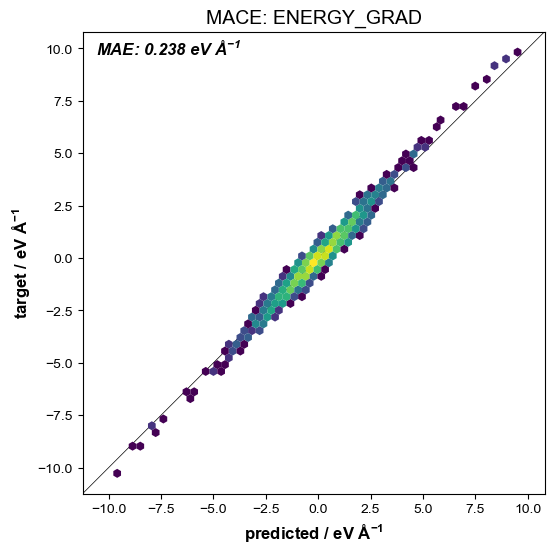

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
key = "energy_grad"
pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

plot_hexbin(pred, targ, ax, key, scale="linear")

ax.set_title("%s: %s" % ("MACE", key.upper()), fontsize=14)

plt.show()

The performance here is pretty bad, but that's the whole reason we're fine-tuning the model. We'll tackle this fine-tuning in the next section.

### Doing the actual fine-tuning

We will freeze the early layers that comprise the learned representations and message passing: `node_embedding` and `interactions` (the `radial_embedding`, `spherical_harmonics`, and `atomic_energies_fn` have no learned parameters). Then, we'll train the remaining layers (`products`, `readouts`) on new data.

In [89]:
mace_freezer = MaceLayerFreezer()

# Freeze all but the readout layers
mace_freezer.model_tl(mace_model, freeze_interactions=True, freeze_products=False)

First, we will need to set up all the parameters for training. We'll make variables to contain our training metrics, hooks for training, and the optimizer. Then, we'll train the model on the new data.

In [90]:
train_metrics = [
    metrics.MeanAbsoluteError("energy_grad"),
]

In [91]:
trainable_params = filter(lambda p: p.requires_grad, mace_model.parameters())
optimizer = Adam(trainable_params, lr=3e-4)
loss_fn = loss.build_mse_loss(loss_coef={"energy_grad": 1000})

Next, we pass the model through the `NFFMACEWrapper` so that it can interface with the `nff` package. The wrapper has a `forward` method that takes inputs as `AtomsBatch` objects, translates them to `torch_geometric` objects, and passes them through the model.

In [92]:
mace_train = Trainer(
    model_path=OUTDIR_MACE,
    model=mace_model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
    model_kwargs={"training": True, "compute_force": True}
    # hooks=train_hooks,
    # retain_graph=True,
)

In [93]:
mace_model.atomic_energies_fn.atomic_energies.dtype

torch.float32

In [94]:
mace_train.train(device=DEVICE, n_epochs=10)

 97%|█████████▋| 35/36 [00:41<00:01,  1.18s/it]


Now, let's evaluate our model again and see if the training has helped.

In [95]:
results, targets, val_loss = evaluate(mace_model, test_loader, loss_fn, device=DEVICE)

100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


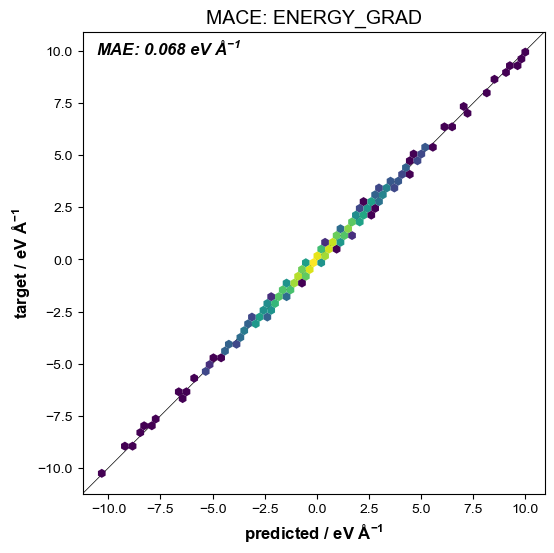

In [96]:
fig, ax = plt.subplots(figsize=(12, 6))
key = "energy_grad"
pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

plot_hexbin(pred, targ, ax, key, scale="linear")

ax.set_title("%s: %s" % ("MACE", key.upper()), fontsize=14)

plt.show()

# Try doing the same tests with CHGNet

Here, we're going to load the NFF wrapper around the pre-trained CHGNet architecture and try training it the same way as we did with MACE above.

In [47]:
chgnet_nff = CHGNetNFF.load("0.3.0")
chgnet_nff.float()

CHGNet v0.3.0 initialized with 412,525 parameters


CHGNetNFF(
  (composition_model): AtomRef(
    (fc): Linear(in_features=94, out_features=1, bias=False)
  )
  (graph_converter): CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3)
  (atom_embedding): AtomEmbedding(
    (embedding): Embedding(94, 64)
  )
  (bond_basis_expansion): BondEncoder(
    (rbf_expansion_ag): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
    (rbf_expansion_bg): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
  )
  (bond_embedding): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_ag): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_bg): Linear(in_features=31, out_features=64, bias=False)
  (angle_basis_expansion): AngleEncoder(
    (fourier_expansion): Fourier()
  )
  (angle_embedding): Linear(in_features=31, out_features=64, bias=False)
  (atom_conv_layers): ModuleList(
    (0-3): 4 x AtomConv(
      (activation): SiLU()
      (twoBody_atom): GatedMLP(
        (ml

In [50]:
chgnet_nff

CHGNetNFF(
  (composition_model): AtomRef(
    (fc): Linear(in_features=94, out_features=1, bias=False)
  )
  (graph_converter): CrystalGraphConverter(algorithm='fast', atom_graph_cutoff=6, bond_graph_cutoff=3)
  (atom_embedding): AtomEmbedding(
    (embedding): Embedding(94, 64)
  )
  (bond_basis_expansion): BondEncoder(
    (rbf_expansion_ag): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
    (rbf_expansion_bg): RadialBessel(
      (smooth_cutoff): CutoffPolynomial()
    )
  )
  (bond_embedding): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_ag): Linear(in_features=31, out_features=64, bias=False)
  (bond_weights_bg): Linear(in_features=31, out_features=64, bias=False)
  (angle_basis_expansion): AngleEncoder(
    (fourier_expansion): Fourier()
  )
  (angle_embedding): Linear(in_features=31, out_features=64, bias=False)
  (atom_conv_layers): ModuleList(
    (0-3): 4 x AtomConv(
      (activation): SiLU()
      (twoBody_atom): GatedMLP(
        (ml

In [49]:
results, targets, val_loss = evaluate(chgnet_nff, test_loader, loss_fn, device=DEVICE)

 20%|██        | 1/5 [00:00<00:00,  5.31it/s]

1 structures imported
1 structures imported


 60%|██████    | 3/5 [00:00<00:00,  4.61it/s]

1 structures imported
1 structures imported


100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

1 structures imported


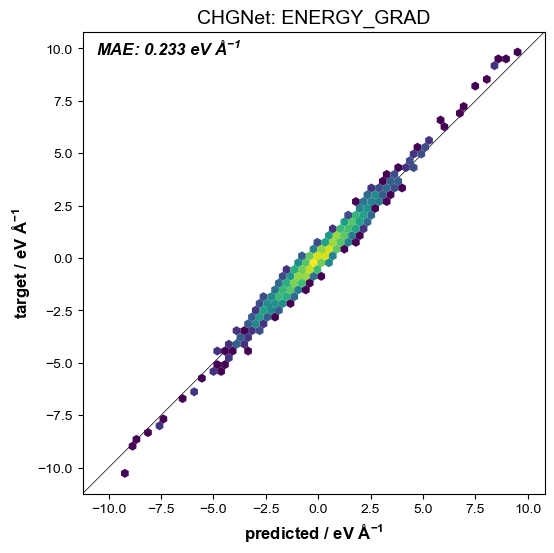

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
key = "energy_grad"
pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

plot_hexbin(pred, targ, ax, key, scale="linear")

ax.set_title("%s: %s" % ("CHGNet", key.upper()), fontsize=14)

plt.show()

In [52]:
chgnet_freezer = ChgnetLayerFreezer()

# Freeze all but the last atom_conv layer, the
# pooling steps, and the final MLP layers
chgnet_freezer.model_tl(chgnet_nff)

In [53]:
loss_fn = loss.build_mse_loss(loss_coef={"energy_grad": 1000})

In [54]:
trainable_params = filter(lambda p: p.requires_grad, chgnet_nff.parameters())
optimizer = Adam(trainable_params, lr=3e-4)

In [55]:
chg_train = Trainer(
    model_path=OUTDIR_CHGNET,
    model=chgnet_nff,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    checkpoint_interval=1,
)

In [56]:
chg_train.train(device=DEVICE, n_epochs=10)

  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:12,  2.83it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:11,  3.08it/s]

1 structures imported


  8%|▊         | 3/36 [00:00<00:10,  3.09it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:10,  3.16it/s]

1 structures imported


 14%|█▍        | 5/36 [00:01<00:10,  2.90it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:11,  2.67it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:11,  2.60it/s]

1 structures imported


 22%|██▏       | 8/36 [00:02<00:10,  2.78it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:10,  2.56it/s]

1 structures imported


 28%|██▊       | 10/36 [00:03<00:09,  2.78it/s]

1 structures imported


 31%|███       | 11/36 [00:03<00:08,  2.94it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:07,  3.03it/s]

1 structures imported


 36%|███▌      | 13/36 [00:04<00:07,  2.89it/s]

1 structures imported


 39%|███▉      | 14/36 [00:04<00:07,  2.81it/s]

1 structures imported


 42%|████▏     | 15/36 [00:05<00:08,  2.51it/s]

1 structures imported


 44%|████▍     | 16/36 [00:05<00:08,  2.36it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:07,  2.46it/s]

1 structures imported


 50%|█████     | 18/36 [00:06<00:07,  2.43it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:06,  2.46it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:07<00:06,  2.62it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:07<00:05,  2.76it/s]

1 structures imported


 61%|██████    | 22/36 [00:08<00:08,  1.61it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:09<00:07,  1.73it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:07,  1.67it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:05,  1.84it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:10<00:04,  2.11it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:03,  2.36it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:03,  2.38it/s]

1 structures imported


 81%|████████  | 29/36 [00:11<00:02,  2.46it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.37it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:12<00:01,  2.53it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.56it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:13<00:01,  2.68it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:13<00:00,  2.80it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.91it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.44it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:15,  2.33it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:12,  2.69it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:13,  2.45it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:11,  2.74it/s]

1 structures imported


 14%|█▍        | 5/36 [00:01<00:11,  2.63it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:10,  2.77it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:09,  2.98it/s]

1 structures imported


 22%|██▏       | 8/36 [00:02<00:10,  2.65it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:09,  2.76it/s]

1 structures imported


 28%|██▊       | 10/36 [00:03<00:08,  2.92it/s]

1 structures imported


 31%|███       | 11/36 [00:03<00:08,  3.08it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:09,  2.58it/s]

1 structures imported


 36%|███▌      | 13/36 [00:04<00:08,  2.58it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:08,  2.53it/s]

1 structures imported


 42%|████▏     | 15/36 [00:05<00:07,  2.73it/s]

1 structures imported


 44%|████▍     | 16/36 [00:05<00:07,  2.65it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:06,  2.80it/s]

1 structures imported


 50%|█████     | 18/36 [00:06<00:06,  2.57it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:06,  2.49it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:07<00:06,  2.55it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:07<00:06,  2.38it/s]

1 structures imported


 61%|██████    | 22/36 [00:08<00:06,  2.28it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:08<00:05,  2.21it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:09<00:05,  2.16it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:09<00:05,  2.15it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:10<00:06,  1.57it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:05,  1.65it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:04,  1.84it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:03,  1.96it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.20it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:02,  2.32it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.37it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:13<00:01,  2.41it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.52it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.73it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.36it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:13,  2.58it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:11,  3.07it/s]

1 structures imported


  8%|▊         | 3/36 [00:00<00:10,  3.27it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:10,  3.11it/s]

1 structures imported


 14%|█▍        | 5/36 [00:01<00:09,  3.25it/s]

1 structures imported


 17%|█▋        | 6/36 [00:01<00:09,  3.32it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:08,  3.31it/s]

1 structures imported


 22%|██▏       | 8/36 [00:02<00:08,  3.13it/s]

1 structures imported


 25%|██▌       | 9/36 [00:02<00:09,  2.83it/s]

1 structures imported


 28%|██▊       | 10/36 [00:03<00:09,  2.80it/s]

1 structures imported


 31%|███       | 11/36 [00:03<00:09,  2.72it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:08,  2.74it/s]

1 structures imported


 36%|███▌      | 13/36 [00:04<00:08,  2.81it/s]

1 structures imported


 39%|███▉      | 14/36 [00:04<00:08,  2.59it/s]

1 structures imported


 42%|████▏     | 15/36 [00:05<00:09,  2.31it/s]

1 structures imported


 44%|████▍     | 16/36 [00:05<00:08,  2.31it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:08,  2.22it/s]

1 structures imported


 50%|█████     | 18/36 [00:06<00:08,  2.18it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:07,  2.23it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:07<00:07,  2.19it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:08<00:06,  2.24it/s]

1 structures imported


 61%|██████    | 22/36 [00:08<00:05,  2.44it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:08<00:05,  2.29it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:09<00:04,  2.54it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:09<00:04,  2.69it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:09<00:03,  2.78it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:10<00:03,  2.57it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:10<00:03,  2.63it/s]

1 structures imported


 81%|████████  | 29/36 [00:11<00:02,  2.34it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:11<00:02,  2.61it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:12<00:02,  2.25it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:12<00:02,  1.86it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:13<00:01,  1.90it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:13<00:01,  1.98it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.07it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.40it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:12,  2.69it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:11,  2.95it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:15,  2.10it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:14,  2.16it/s]

1 structures imported


 14%|█▍        | 5/36 [00:02<00:12,  2.43it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:12,  2.36it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:12,  2.30it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:12,  2.33it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:10,  2.55it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:10,  2.57it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:09,  2.70it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:08,  2.87it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:07,  2.92it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:07,  3.07it/s]

1 structures imported


 42%|████▏     | 15/36 [00:05<00:06,  3.17it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:07,  2.80it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:07,  2.54it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:08,  2.12it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:07,  2.27it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:07,  2.25it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:08<00:06,  2.20it/s]

1 structures imported


 61%|██████    | 22/36 [00:08<00:06,  2.32it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:09<00:05,  2.46it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:09<00:04,  2.64it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:04,  2.48it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:10<00:04,  2.36it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:10<00:03,  2.32it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:03,  2.56it/s]

1 structures imported


 81%|████████  | 29/36 [00:11<00:02,  2.43it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.35it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:12<00:02,  2.30it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.12it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:13<00:01,  2.29it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:13<00:00,  2.29it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.56it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.31it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:12,  2.86it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:13,  2.46it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:14,  2.33it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:13,  2.44it/s]

1 structures imported


 14%|█▍        | 5/36 [00:02<00:12,  2.48it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:14,  2.12it/s]

1 structures imported


 19%|█▉        | 7/36 [00:03<00:13,  2.14it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:13,  2.11it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:12,  2.21it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:10,  2.43it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:10,  2.41it/s]

1 structures imported


 33%|███▎      | 12/36 [00:05<00:10,  2.37it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:09,  2.53it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:08,  2.51it/s]

1 structures imported


 42%|████▏     | 15/36 [00:06<00:08,  2.40it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:08,  2.26it/s]

1 structures imported


 47%|████▋     | 17/36 [00:07<00:08,  2.18it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:08,  2.15it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:08<00:08,  2.11it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:07,  2.26it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:09<00:07,  2.02it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:06,  2.14it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:10<00:05,  2.39it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:04,  2.58it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:04,  2.50it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:11<00:04,  2.38it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:03,  2.44it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:03,  2.57it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:02,  2.50it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.43it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:02,  2.50it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.59it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:14<00:01,  2.43it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.34it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  1.82it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.20it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:15,  2.24it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:12,  2.81it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:13,  2.49it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:13,  2.43it/s]

1 structures imported


 14%|█▍        | 5/36 [00:01<00:11,  2.65it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:11,  2.62it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:11,  2.63it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:10,  2.69it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:11,  2.26it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:10,  2.38it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:09,  2.55it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:08,  2.73it/s]

1 structures imported


 36%|███▌      | 13/36 [00:04<00:07,  2.88it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:08,  2.61it/s]

1 structures imported


 42%|████▏     | 15/36 [00:05<00:08,  2.49it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:08,  2.36it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:08,  2.30it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:08,  2.23it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:07,  2.28it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:06,  2.32it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:08<00:07,  2.13it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:06,  2.24it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:09<00:06,  2.15it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:06,  1.90it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:05,  2.02it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:10<00:04,  2.29it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:03,  2.51it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:02,  2.72it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:02,  2.53it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.44it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:12<00:01,  2.62it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.42it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:13<00:01,  2.38it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.27it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.24it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.32it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:15,  2.31it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:14,  2.33it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:14,  2.23it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:13,  2.35it/s]

1 structures imported


 14%|█▍        | 5/36 [00:02<00:13,  2.31it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:12,  2.47it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:11,  2.49it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:11,  2.40it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:10,  2.64it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:10,  2.51it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:09,  2.55it/s]

1 structures imported


 33%|███▎      | 12/36 [00:05<00:10,  2.25it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:10,  2.23it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:10,  2.18it/s]

1 structures imported


 42%|████▏     | 15/36 [00:06<00:09,  2.27it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:08,  2.45it/s]

1 structures imported


 47%|████▋     | 17/36 [00:07<00:08,  2.34it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:08,  2.23it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:08<00:07,  2.18it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:07,  2.14it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:09<00:07,  2.14it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:06,  2.12it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:10<00:06,  2.09it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:05,  2.09it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:11<00:05,  2.10it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:11<00:04,  2.13it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:12<00:04,  2.00it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:12<00:03,  2.07it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:03,  2.14it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:13<00:02,  2.38it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:01,  2.60it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.53it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:14<00:01,  2.60it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.75it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.82it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.27it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:16,  2.11it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:15,  2.19it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:12,  2.58it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:12,  2.53it/s]

1 structures imported


 14%|█▍        | 5/36 [00:02<00:12,  2.50it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:11,  2.56it/s]

1 structures imported


 19%|█▉        | 7/36 [00:02<00:11,  2.57it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:11,  2.54it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:10,  2.62it/s]

1 structures imported


 28%|██▊       | 10/36 [00:03<00:09,  2.81it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:08,  2.97it/s]

1 structures imported


 33%|███▎      | 12/36 [00:04<00:09,  2.65it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:09,  2.47it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:09,  2.43it/s]

1 structures imported


 42%|████▏     | 15/36 [00:06<00:09,  2.22it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:08,  2.31it/s]

1 structures imported


 47%|████▋     | 17/36 [00:06<00:08,  2.22it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:08,  2.23it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:07<00:07,  2.19it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:07,  2.11it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:08<00:07,  1.96it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:06,  2.01it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:09<00:06,  2.13it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:05,  2.22it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:04,  2.21it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:11<00:04,  2.04it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:04,  2.04it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:12<00:03,  2.20it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:03,  2.04it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:13<00:02,  2.31it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:02,  2.33it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.56it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:14<00:01,  2.51it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.67it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:14<00:00,  2.57it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.28it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:15,  2.31it/s]

1 structures imported


  6%|▌         | 2/36 [00:01<00:26,  1.30it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:21,  1.50it/s]

1 structures imported


 11%|█         | 4/36 [00:02<00:17,  1.88it/s]

1 structures imported


 14%|█▍        | 5/36 [00:02<00:13,  2.24it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:12,  2.49it/s]

1 structures imported


 19%|█▉        | 7/36 [00:03<00:10,  2.64it/s]

1 structures imported


 22%|██▏       | 8/36 [00:03<00:09,  2.83it/s]

1 structures imported


 25%|██▌       | 9/36 [00:03<00:09,  2.98it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:09,  2.82it/s]

1 structures imported


 31%|███       | 11/36 [00:04<00:08,  2.94it/s]

1 structures imported


 33%|███▎      | 12/36 [00:05<00:09,  2.63it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:08,  2.56it/s]

1 structures imported


 39%|███▉      | 14/36 [00:05<00:08,  2.75it/s]

1 structures imported


 42%|████▏     | 15/36 [00:06<00:08,  2.51it/s]

1 structures imported


 44%|████▍     | 16/36 [00:06<00:08,  2.38it/s]

1 structures imported


 47%|████▋     | 17/36 [00:07<00:08,  2.30it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:09,  1.92it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:08<00:08,  1.95it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:08,  1.95it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:09<00:07,  1.97it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:06,  2.09it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:10<00:06,  2.08it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:05,  2.30it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:04,  2.46it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:11<00:04,  2.46it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:03,  2.28it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:12<00:03,  2.51it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:02,  2.71it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.53it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:02,  2.47it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:14<00:01,  2.07it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:14<00:01,  2.18it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.15it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.16it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.21it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


  0%|          | 0/36 [00:00<?, ?it/s]

1 structures imported


  3%|▎         | 1/36 [00:00<00:13,  2.67it/s]

1 structures imported


  6%|▌         | 2/36 [00:00<00:11,  2.99it/s]

1 structures imported


  8%|▊         | 3/36 [00:01<00:11,  2.75it/s]

1 structures imported


 11%|█         | 4/36 [00:01<00:11,  2.83it/s]

1 structures imported


 14%|█▍        | 5/36 [00:01<00:11,  2.59it/s]

1 structures imported


 17%|█▋        | 6/36 [00:02<00:18,  1.59it/s]

1 structures imported


 19%|█▉        | 7/36 [00:03<00:16,  1.73it/s]

1 structures imported


 22%|██▏       | 8/36 [00:04<00:16,  1.72it/s]

1 structures imported


 25%|██▌       | 9/36 [00:04<00:14,  1.90it/s]

1 structures imported


 28%|██▊       | 10/36 [00:04<00:12,  2.09it/s]

1 structures imported


 31%|███       | 11/36 [00:05<00:10,  2.34it/s]

1 structures imported


 33%|███▎      | 12/36 [00:05<00:09,  2.44it/s]

1 structures imported


 36%|███▌      | 13/36 [00:05<00:09,  2.51it/s]

1 structures imported


 39%|███▉      | 14/36 [00:06<00:08,  2.49it/s]

1 structures imported


 42%|████▏     | 15/36 [00:06<00:08,  2.46it/s]

1 structures imported


 44%|████▍     | 16/36 [00:07<00:07,  2.57it/s]

1 structures imported


 47%|████▋     | 17/36 [00:07<00:07,  2.46it/s]

1 structures imported


 50%|█████     | 18/36 [00:07<00:07,  2.47it/s]

1 structures imported


 53%|█████▎    | 19/36 [00:08<00:06,  2.57it/s]

1 structures imported


 56%|█████▌    | 20/36 [00:08<00:06,  2.46it/s]

1 structures imported


 58%|█████▊    | 21/36 [00:09<00:07,  2.11it/s]

1 structures imported


 61%|██████    | 22/36 [00:09<00:05,  2.35it/s]

1 structures imported


 64%|██████▍   | 23/36 [00:10<00:05,  2.31it/s]

1 structures imported


 67%|██████▋   | 24/36 [00:10<00:04,  2.45it/s]

1 structures imported


 69%|██████▉   | 25/36 [00:10<00:04,  2.48it/s]

1 structures imported


 72%|███████▏  | 26/36 [00:11<00:03,  2.66it/s]

1 structures imported


 75%|███████▌  | 27/36 [00:11<00:03,  2.54it/s]

1 structures imported


 78%|███████▊  | 28/36 [00:11<00:03,  2.50it/s]

1 structures imported


 81%|████████  | 29/36 [00:12<00:02,  2.41it/s]

1 structures imported


 83%|████████▎ | 30/36 [00:12<00:02,  2.30it/s]

1 structures imported


 86%|████████▌ | 31/36 [00:13<00:02,  2.50it/s]

1 structures imported


 89%|████████▉ | 32/36 [00:13<00:01,  2.43it/s]

1 structures imported


 92%|█████████▏| 33/36 [00:14<00:01,  2.31it/s]

1 structures imported


 94%|█████████▍| 34/36 [00:14<00:00,  2.32it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.06it/s]

1 structures imported


 97%|█████████▋| 35/36 [00:15<00:00,  2.26it/s]


1 structures imported
1 structures imported
1 structures imported
1 structures imported
1 structures imported


In [57]:
results, targets, val_loss = evaluate(chgnet_nff, test_loader, loss_fn, device=DEVICE)

  0%|          | 0/5 [00:00<?, ?it/s]

1 structures imported


 20%|██        | 1/5 [00:00<00:00,  4.23it/s]

1 structures imported


 60%|██████    | 3/5 [00:00<00:00,  5.21it/s]

1 structures imported
1 structures imported


 80%|████████  | 4/5 [00:00<00:00,  5.06it/s]

1 structures imported


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


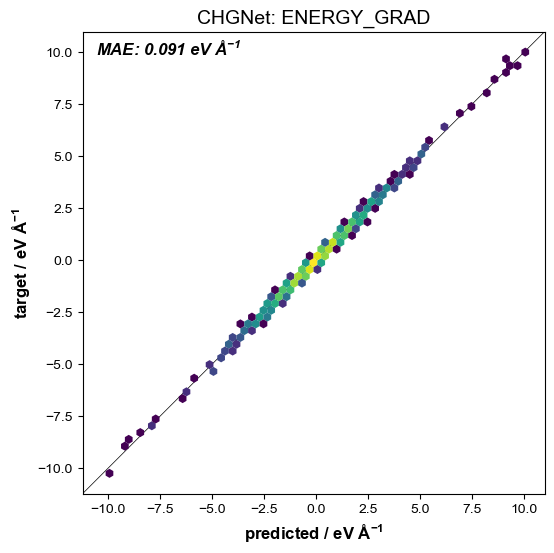

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
key = "energy_grad"
pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)

plot_hexbin(pred, targ, ax, key, scale="linear")

ax.set_title("%s: %s" % ("CHGNet", key.upper()), fontsize=14)

plt.show()